<a href="https://colab.research.google.com/github/ML4SCI/ML4SCIHackathon/blob/main/NMRSpinChallenge/Hackathon_NMR_Challenge_Nov2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Hackathon - NMR Challenge


### Problem Statement

- Nuclear Magnetic Resonance (NMR) is an experimental technique that allows for the control and measurement of nuclear spins in crystals and molecules.
- A common "recipe" for NMR is called the spin echo: the spins start aligned, begin to disperse, and are then refocused. This creates a sharp peak, or "echo", in the net magnetization $M$ of the material at a later time. When the spins interact with each other, this refocused echo can become highly distorted.
- Materials with strong electron-electron couplings have a variety of applications, from superconductivity to ferromagnetism. They also tend to enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of these important systems.
- Design and train a model that predicts the strength and shape of interactions between the nuclear spins from simulated time-dependent magnetization curves, $M(t)$.

Before getting to any code, we first review the structure of this machine learning problem and introduce some of the details of the underlying physics we are trying to capture.




## Quick description of the ML problem

### Goal:
Predict three numbers from a large input vector of real numbers.

### Example Solution:  Multilayer Neural Network (see code after this introduction)

To get the complex-valued time-series $M(t)$ into a neural network, we can simply "stack" the real and complex parts together to make a real-valued input vector.



## Introduction to NMR and spin echos

Although the NMR "spin echo" technique may sound complicated, the following animation created by Gavin W Morley (by way of https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!


![NMR Spin Echo Animation](HahnEcho_GWM.gif)


The red arrows in this animation represents the values of nuclear spins in the material.
They all begin in the same direction (up), and then an applied magnetic field rotates them into the x-y plane (indicated by the 90$^\circ$ pulse).
A constant external magnetic field in the z-direction did not affect the spins when they were pointing "up", but now that they lie in the x-y plane they begin to precess.


Because each nuclear spin sits in a slightly different magnetic environment, each one has a slightly different response to the background z-direction magnetic field, causing some to precess in a clockwise direction and others in a counterclockwise direction.


After a fixed amount of time, $t$ in the above animation, a second magnetic pulse is applied and rotates each spin 180$^\circ$ in the x-y plane.
After this, the spins continue to move as they did before, but because of the 180$^\circ$ pulse they are now effectively precessing  "backwards" compared to the original motion!
So after an additional time $t$ passes, the variations in precession time is canceled out, causing a refocusing of the spins.

This shows up as a measurable "echo" in the average spin magnetization of the material, and can be measured in experiments.
This is an important technique because the average spin magnetization is hard to measure during an applied "pulse", but there is no external pulse during the "echo", allowing for accurate measurement of the peak value and decay shape.

In the following, we will use simulated data that studies how the magnetization depends on the interaction between spins, $\alpha$, and the effective flip angle for the first pulse, $\theta$.
In spin echo experiments, one tries to apply a $\theta = $ 90$^\circ$ pulse as in the above example, but in practice it is a hard thing to do!
Therefore, we will consider cases where the spins are not always exactly inplane after the first pulse ($\theta \neq $ 90$^\circ$).
For example, the following diagram shows a pulse angle of $\theta \approx $ 40$^\circ$.

![spin_interaction_diagram.png](spin_interaction_diagram.png)


Here are examples of the time-dependent in-plane magnetization $M(t) = M_x(t) + i M_y(t)$ for a spin-echo materials ($M_x$ in red, $M_y$ in blue):

![standard_spinecho.png](spin_echo_examples.png)

The first example is a fairly standard spin echo: the average magnetization decays quite fast after the first $\theta \approx 90^\circ$ pulse, and re-appears an equal time after the $2\theta \approx 180^\circ$ pulse as an "echo"!

The second more complicated example have been caused by spin-spin interactions between the precessing nuclear spins and a flip-angle $\theta$ not near 90$^\circ$. Normally, each spin precesses in a uniform way irrespective of the rest of the nuclei in the material. In this coupled case, however, the nuclear magnetization that occurs near the "echo" influences the spins' motions, modifying the shape of the observed echo.

The final case shows all 3,000 $M(t)$ curves from the simualtion dataset we will be using. Since most experiments do not have access to low-noise data near the $\theta$ and $2\theta$ pulse times, we will only be using the region given within the green lines, $t \in [130,270]$ $\mu$s.

## Electronic and nuclear spins

Most materials can be classified by their electronic properties into three categories: metal, insulator, and semiconductor.
These terms are based on a semi-classical description of the electrons in a crystal.
The electrons are treated as a collection of classical particles, with energies that depend on their momentum in a way determined by the atomic structure of the crystal.

However, there are other electronic phases of matter that are truly "quantum" and cannot be described accurately with a classical analogy.
In these scenarios, complicated structures in the electron states can give rise to large electronic spin density or strong electron-electron coupling.
Because of these strong couplings between electrons, they are often hard to probe experimentally.

Luckily, electrons can interact with the nuclear spins of a material (by way of the hyperfine-interaction).
If the electron-nuclear coupling becomes strong enough (mediated perhaps by a strongly correlated electronic phase), then the nuclear spins will couple throughout the material.
This can be viewed as a two-step process, where a nuclear spin couples to an electron and changes its motion, and then that electron later "scatters" off another nuclear spin elsewhere in the material.

We here make the simplifying assumption that this scattering effect is determined by only three variables:

$\alpha_x$: The effective scattering strength for nuclear spins when the spin-axis is perpindicular to the $z$-direction (perpindicular to the constant magnetic field). Note that we call this $\alpha_x$ but it defines the coupling in the entire $xy$ plane.

$\alpha_z$: The effective scattering strength for nuclear spins when the spin-axis is along the $z$-direction (parallel to the constant magnetic field)

$\theta$: The "flip angle" of the nuclear spins caused by the strength of the applied pulse at $t=0$ and $t=\tau$. In an ideal spin-echo experiment, $\theta =$ 90$^\circ$, but in practice the exact flip-angle is never known.


Here we provide simulated spin-echo magnetizations $M(t)$ from random samples of these three parameters to see if the spin-echo experiment can provide enough information to accurately "reverse engineer" them from a single $M(t)$ curve.


In the simulated data-sets, the parameters are randomly distributed over the following ranges:
- $\alpha_x$: coupling strength $\in$ [0, 100] kHz
- $\alpha_z$: coupling strength $\in$ [0, 300] kHz
- $\theta$: flip angle $\in$ [10$^\circ$,90$^\circ$]

Our goal is to develop a model that accurately determines the above three variables from a single $M(t)$ curve.

For more detail on the coupled spil model and details of the simulations, see the recent preprint: https://arxiv.org/abs/2110.06811

## Load and view the simulated data

Three data-files will be used for the training of the model. Each has 3,000 lines, representing 3,000 simulated $M(t)$ curves for different choices of the three material parameters:

- echos_r.txt  : Real part of the time-dependent magnetization, $\textrm{Re}(M(t))$.
- echos_i.txt  : Imaginary part of the time-dependent magnetization, $\textrm{Im}(M(t))$.
- mat_info.txt : The three material parameters ($\alpha_x$,$\alpha_z$,$\theta$) introduced above.

We also download two smaller files, which give the 1000 $M(t)$ curves to be used in submitting your solution to the challenge:

- submit_echos_r.txt
- submit_echos_i.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests

mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

M_file_r_submit = "submit_echos_r.txt" # real part of echos
M_file_i_submit = "submit_echos_i.txt" # real part of echos

print("Downloading files off google drive...")

# data for model creation
r = requests.get("https://docs.google.com/uc?export=download&id=1kDfBub8Vc-T9WDGvrsuG4_v-RDqyQxUI",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1Cl1CXXs90hzlOHE0IfCcTqUfHhNrltbX",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1aKa5KQZopEqLA8hSsOVewfGE9VI8kWrL",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
r = requests.get("https://docs.google.com/uc?export=download&id=1J__da9y_N1C4u2EC4OaIG0DDi14kufFT",allow_redirects=True)
open("submit_echos_r.txt", "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1aGRd3-NNSv1DXf1S51cb_W19RBvaatId",allow_redirects=True)
open("submit_echos_i.txt", "wb").write(r.content)

print("Done with file downloads")

print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α_x (MHz)  |   α_z (MHz)   |   θ (radians)  |
mat_info = np.loadtxt(mat_file);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r);
M_i = np.loadtxt(M_file_i);
M = M_r + 1j*M_i;

M_r_submit = np.loadtxt(M_file_r_submit);
M_i_submit = np.loadtxt(M_file_i_submit);
print("Done with numpy loads")



Done with file downloads
Loading into numpy arrays...
Done with numpy loads


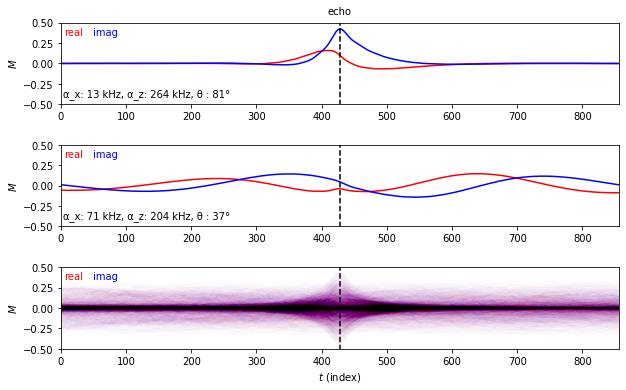

In [3]:
# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(3,1, figsize=(10,6));

# change the following to see different curves
plot_idx1 = 2; # weak spin-spin coupling
plot_idx2 = 0; # strong spin-spin coupling

# string format for material parameter plotting
mat_format = "α_x: %d kHz, α_z: %d kHz, θ : %d°";

nt = np.shape(M)[1]

# view the selected curve, with a label of the material data
ax1[0].plot(np.real(M[plot_idx1,:]),color='r');
ax1[0].plot(np.imag(M[plot_idx1,:]),color='b');

# view the selected curve, with a label of the material data
ax1[1].plot(np.real(M[plot_idx2,:]),color='r');
ax1[1].plot(np.imag(M[plot_idx2,:]),color='b');

# view all data with an opacity channel
ax1[2].plot(np.real(M[:,:]).T,color=(1,0,0,.0025));
ax1[2].plot(np.imag(M[:,:]).T,color=(0,0,1,.0025));

text_h = 0.6;

# notes on the plots
ax1[0].text(4,-0.4, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].text(nt/2,text_h,"echo",ha='center')
ax1[0].plot([nt/2, nt/2],[-1, 1],'--k')
ax1[0].set(ylabel="$M$");
ax1[0].axis([0,nt, -0.5, 0.5])
ax1[0].text(5,0.35,"real",color='r')
ax1[0].text(50,0.35,"imag",color='b')

ax1[1].text(4,-0.4, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([nt/2, nt/2],[-1, 1],'--k')
ax1[1].set(ylabel="$M$");
ax1[1].axis([0,nt, -0.5, 0.5])
ax1[1].text(5,0.35,"real",color='r')
ax1[1].text(50,0.35,"imag",color='b')

ax1[2].set(ylabel="$M$", xlabel="$t$ (index)");
ax1[2].axis([0,nt, -0.5, 0.5])
ax1[2].plot([nt/2, nt/2],[-1, 1],'--k')
ax1[2].text(5,0.35,"real",color='r')
ax1[2].text(50,0.35,"imag",color='b')

fig1.subplots_adjust(hspace=.5)


In [4]:
mat_info_n = np.zeros(np.shape(mat_info), float)
transform_info = np.zeros( (2,3), float)
for idx in range(np.shape(mat_info)[1]):
    dat = mat_info[:,idx]
    mu, sigma = np.mean(dat), np.std(dat)
    transform_info[:,idx] = [mu, sigma]
    mat_info_n[:,idx] = (dat - mu)/sigma
    

M_max = np.max(np.abs(M))
M_n = M/M_max
M_n = np.concatenate( (np.real(M_n),np.imag(M_n)) , axis=1)


In [5]:
from torch.utils.data import Dataset

class SpinechoDataset(Dataset):
    def __init__(self, X, y):
        self.data = X # spin echos M
        self.target = y # param data
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        return x, y
    
    def __len__(self):
        return len(self.data)

In [6]:
from torch.utils.data import DataLoader, random_split

dataset = SpinechoDataset(M_n,mat_info_n);
N = len(dataset)
N_train = int(0.8*N);
training_data, test_data = random_split(dataset,[N_train,N-N_train])

train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

## Example solution: a simple neural net (NN)
- Our input nodes are the vector $[\textrm{Re}M(t), \textrm{Im}(M(t))]$
- Our output nodes are the three material parameters.
- We will use a standard NN predict the material properties from $M(t)$.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Net(nn.Module):

    def __init__(self, N):
        super(Net, self).__init__()
        
        # N: number of time points
        
        # need to make a NN that goes from N to 4, let's try 4 layers here!
        self.l1 = nn.Linear(N,24) # try to get key features
        self.l2 = nn.Linear(24,3) # 3 output channels

    def forward(self, x):
        x = F.relu(self.l1(x)) # relu activation
        x = self.l2(x) # gaussian mix
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


N = np.shape(M_n[0])[0]
net = Net(N)
net = net.double()
print(net);
    


Net(
  (l1): Linear(in_features=1712, out_features=24, bias=True)
  (l2): Linear(in_features=24, out_features=3, bias=True)
)


In [8]:
# pick optimizer and train
import torch.optim as optim

#criterion = nn.MSELoss() # mean-square error loss
criterion = nn.SmoothL1Loss() # smooth loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # gradient descent, simple

n_epochs = 200; # number of epochs, can get some improvement by increasing but be careful of overfitting

print('Starting Training')
for epoch in range(n_epochs):  # loop over the dataset for each epoch

    running_loss = 0.0
    for x,y in train_dataloader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()


    if (epoch % 10 == 0):
        print('[%d] loss: %.3f' %
          (epoch + 1, running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

Starting Training
[1] loss: 0.069
[11] loss: 0.050
[21] loss: 0.046
[31] loss: 0.044
[41] loss: 0.043
[51] loss: 0.041
[61] loss: 0.040
[71] loss: 0.038
[81] loss: 0.037
[91] loss: 0.036
[101] loss: 0.035
[111] loss: 0.035
[121] loss: 0.034
[131] loss: 0.033
[141] loss: 0.033
[151] loss: 0.032
[161] loss: 0.032
[171] loss: 0.031
[181] loss: 0.031
[191] loss: 0.030
Finished Training


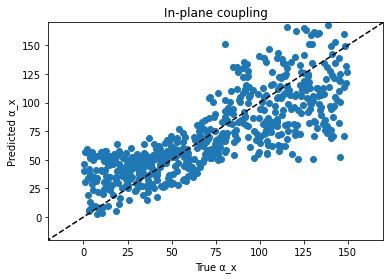

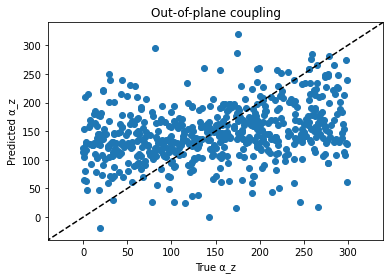

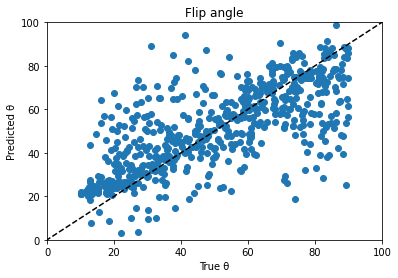

In [9]:
# check results on test set

nn_info = np.empty((0,3), float)
true_info = np.empty((0,3), float)
for x,y in test_dataloader:
    outputs = net(x)
    nn_info = np.append(nn_info,outputs.detach().numpy(),axis=0)
    true_info = np.append(true_info,y.detach().numpy(),axis=0)

# inverse transform... no built-ins in for this in pytorch :(
for idx in range(np.shape(true_info)[1]):
    mu, sigma = transform_info[:,idx]
    true_info[:,idx] = (true_info[:,idx]*sigma) + mu
    nn_info[:,idx] = (nn_info[:,idx]*sigma) + mu
    
plt.scatter(true_info[:,0],nn_info[:,0]);
plt.plot([-1000, 1000],[-1000, 1000],"--k")
plt.xlabel("True α_x");
plt.ylabel("Predicted α_x");
plt.axis([-20,170, -20, 170])
plt.title("In-plane coupling")

plt.figure()
plt.scatter(true_info[:,1],nn_info[:,1]);
plt.plot([-1000, 1000],[-1000, 1000],"--k")
plt.xlabel("True α_z");
plt.ylabel("Predicted α_z");
plt.axis([-40,340, -40, 340])
plt.title("Out-of-plane coupling")

plt.figure()
plt.scatter(true_info[:,2],nn_info[:,2]);
plt.plot([-1000, 1000],[-1000, 1000],"--k")
plt.xlabel("True θ");
plt.ylabel("Predicted θ");
plt.axis([0, 100, 0, 100])
plt.title("Flip angle");




## Submission format

When we downloaded the data for the model development, we also downloaded 1000 spin echos into "submit_echos_r.txt" and "submit_echos_i.txt".
These share the same format as the "echos.txt" used for the model training above.

REMEMBER TO PREPROCESS THESE IN THE SAME WAY BEFORE PASSING TO YOUR MODEL!

Use your model to predict the four spin-interaction variables from the 1000 echos, and submit your results in a space delimited .txt file of dimensions 1000 x 3 matching the "mat_info.txt" format.

That is, the columns should be:

| $\alpha_x$ | $\alpha_z$ | $\theta$ |
      
and there should be 1000 rows.

REMEBER TO UN-NORMALIZE YOUR PREDICTED VALUES SO THEY MATCH THE SCALE OF THE ORIGINAL "mat_info.txt"!

Name this file "submitted_mat_info.txt"

The quality of the model will be judged by the minimization of the error function:


$\textrm{Err} = \sum_{i=1}^{3} \sum_{j=1}^{1000} \left( T_j^i - P_j^i \right)^2 $


where $T_j^i$ is the $j$'th true parameter for the $i$'th echo, and $P_j^i$ is the respective predicted one you submit, in a normalized scaling.

Your submission should include your notebook as well as the predicted value file "submitted_mat_info.txt"



## Contributors

- Stephen Carr (Brown Theoretical Physics Center)
- Charles Snider (Brown University)
- J. B. Marston (Brown Theoretical Physics Center)
- V. F. Mitrović (Brown University)
- D. E. Feldman (Brown Theoretical Physics Center)
- C. Ramanathan (Dartmouth College)